In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from mean_reversion import mean_reversion_strategy, backtest, fetch_data
random_state = 0
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [8]:
df = fetch_data('XOM', '2017-01-01', '2023-12-31')
df = mean_reversion_strategy(df)
result_df, mets = backtest(df)
print(mets)

{'Total Return': -0.05934077041323926, 'Sharpe Ratio': -0.024609839317143167, 'Max Drawdown': -0.21531899523829712}


In [13]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'MA', 'Z Score', 'BB_MA', 'BB_Std', 'BB_Upper', 'BB_Lower', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'RSI', 'Volume_SMA', 'Long', 'Short',
       'Signal', 'Position', 'Return', 'Strategy Return', 'Equity',
       'Drawdown'],
      dtype='object')

### Defining Functions

Need to make lookback period for data

In [59]:
def prep_data(df, col='Close', predictors = ['Open', 'Volume'], prior_days=30):
    # df['BB_Upper', 'BB_Lower', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'MA'].shift(-1)
    X = []
    y = []
    for i in range(len(df) - prior_days):
        X.append(df.iloc[i:i+prior_days][predictors].values)
        y.append(df.iloc[i+prior_days][col])
    return np.array(X), np.array(y)

### Prep Data

In [60]:
X, y = prep_data(df, predictors=['Volume','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

### Standardize Data

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Model

In [52]:
model = RandomForestRegressor(n_estimators=100, random_state=random_state, max_depth=10)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

### Model Prediction

In [53]:
y_pred = model.predict(X_test_scaled)

### Evaluation

In [54]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 134.54674568546753
R2 Score: 0.7220067776807764


In [40]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,Z Score,BB_MA,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,MACD_Hist,RSI,Volume_SMA,Long,Short,Signal,Position,Return,Strategy Return,Equity,Drawdown
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00-05:00,63.504274,63.783594,62.952609,63.469357,10360600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,False,False,0,NaN,NaN,NaN,10000.000000,0.000000
2017-01-04 00:00:00-05:00,63.629953,63.650902,62.673268,62.771030,9434200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.055707,-0.011141,-0.044566,NaN,NaN,False,False,0,0.0,-0.011003,-0.0,10000.000000,0.000000
2017-01-05 00:00:00-05:00,62.980547,63.057361,61.758505,61.835320,14443200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.173361,-0.043585,-0.129775,NaN,NaN,False,False,0,0.0,-0.014907,-0.0,10000.000000,0.000000
2017-01-06 00:00:00-05:00,62.002918,62.135598,61.325557,61.800407,16518100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.266349,-0.088138,-0.178211,NaN,NaN,False,False,0,0.0,-0.000565,-0.0,10000.000000,0.000000
2017-01-09 00:00:00-05:00,61.604870,61.604870,60.438695,60.780865,13762300,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.417499,-0.154010,-0.263489,NaN,NaN,False,False,0,0.0,-0.016497,-0.0,10000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,99.748140,100.362369,99.270412,99.358162,12921800,0.0,0.0,98.690312,0.383155,98.690312,1.743027,102.176366,95.204257,-0.689042,-1.098018,0.408975,48.316084,24157235.0,False,False,0,0.0,0.001769,0.0,9406.592296,-0.088023
2023-12-26 00:00:00-05:00,100.167372,100.450111,99.562902,99.582397,16835100,0.0,0.0,98.601591,0.597174,98.601591,1.642413,101.886416,95.316765,-0.575949,-0.993604,0.417655,56.213412,24098315.0,False,False,0,0.0,0.002257,0.0,9406.592296,-0.088023
2023-12-27 00:00:00-05:00,99.484900,99.982132,98.802424,99.114418,14558800,0.0,0.0,98.492395,0.408726,98.492395,1.521858,101.536110,95.448680,-0.518111,-0.898506,0.380394,59.937654,23794780.0,False,False,0,0.0,-0.004699,-0.0,9406.592296,-0.088023


IndexError: list index out of range

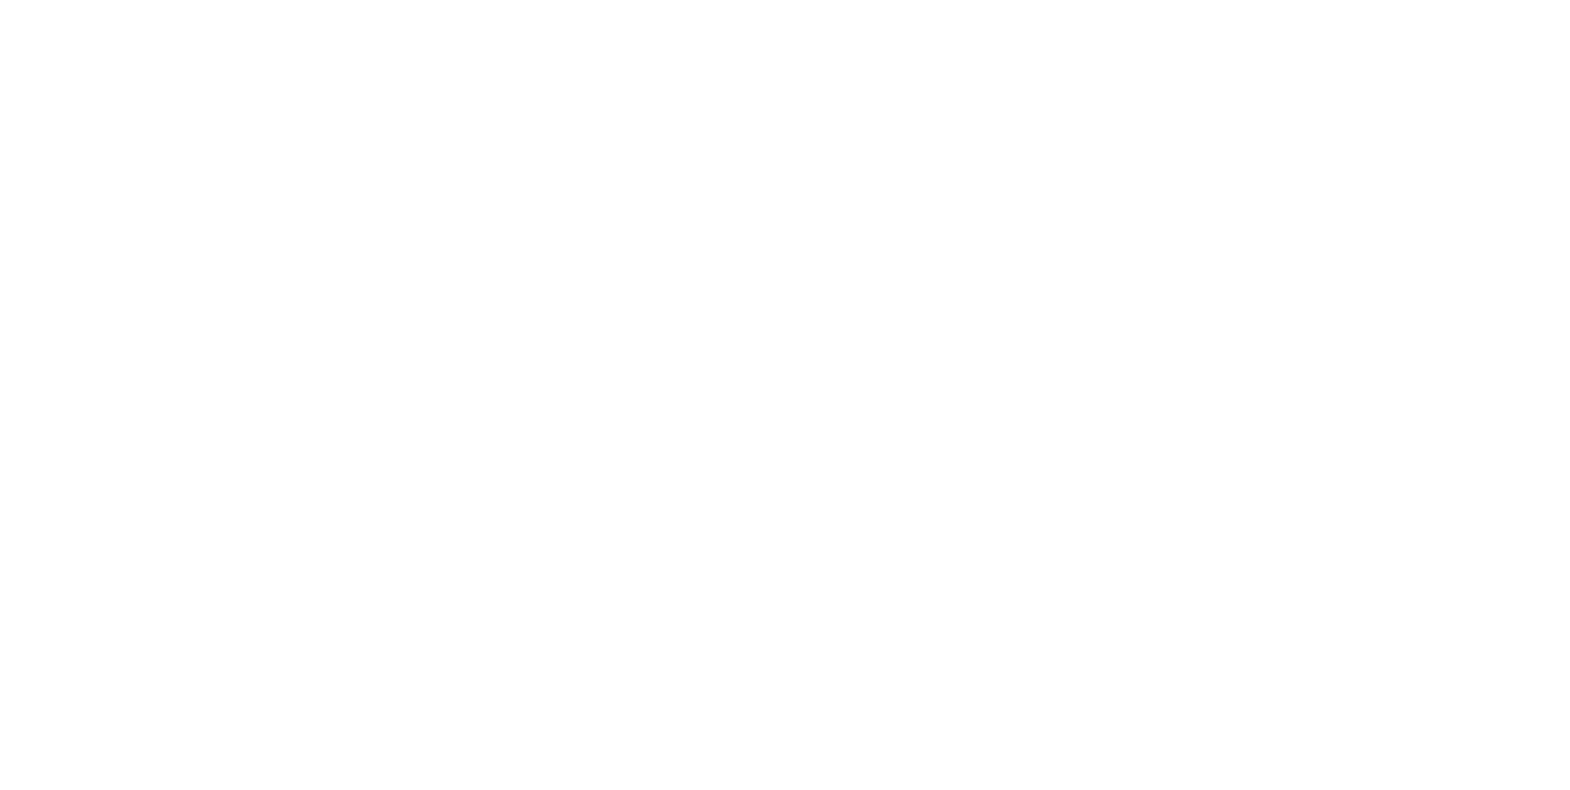

In [38]:
tree = model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'], filled=True)
plt.show()